<a href="https://colab.research.google.com/github/Xanzud/CarpricePrediction-IE500618/blob/main/CarPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Car price prediction

Data taken from https://www.kaggle.com/datasets/CooperUnion/cardataset?resource=download

First, need to install category_encoders, as it is not part of google colaboratory's default python intallation.

In [781]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [782]:
from google.colab import files
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.utils import shuffle 
from category_encoders import OneHotEncoder, TargetEncoder
import warnings
warnings.filterwarnings("ignore")
sns.set(rc = {'figure.figsize': (20, 20)})
%matplotlib inline 

#Importing data from Github repo at https://github.com/Xanzud/CarpricePrediction-IE500618
#Dataset covers years 1990 - 2017
data_url = "https://raw.githubusercontent.com/Xanzud/CarpricePrediction-IE500618/main/CarData.csv"
df1 = pd.read_csv(data_url)


## Exploring the data, attempting to gain some usefull insight.

In [783]:
print("//////////////////////////")
df1.info()


//////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  


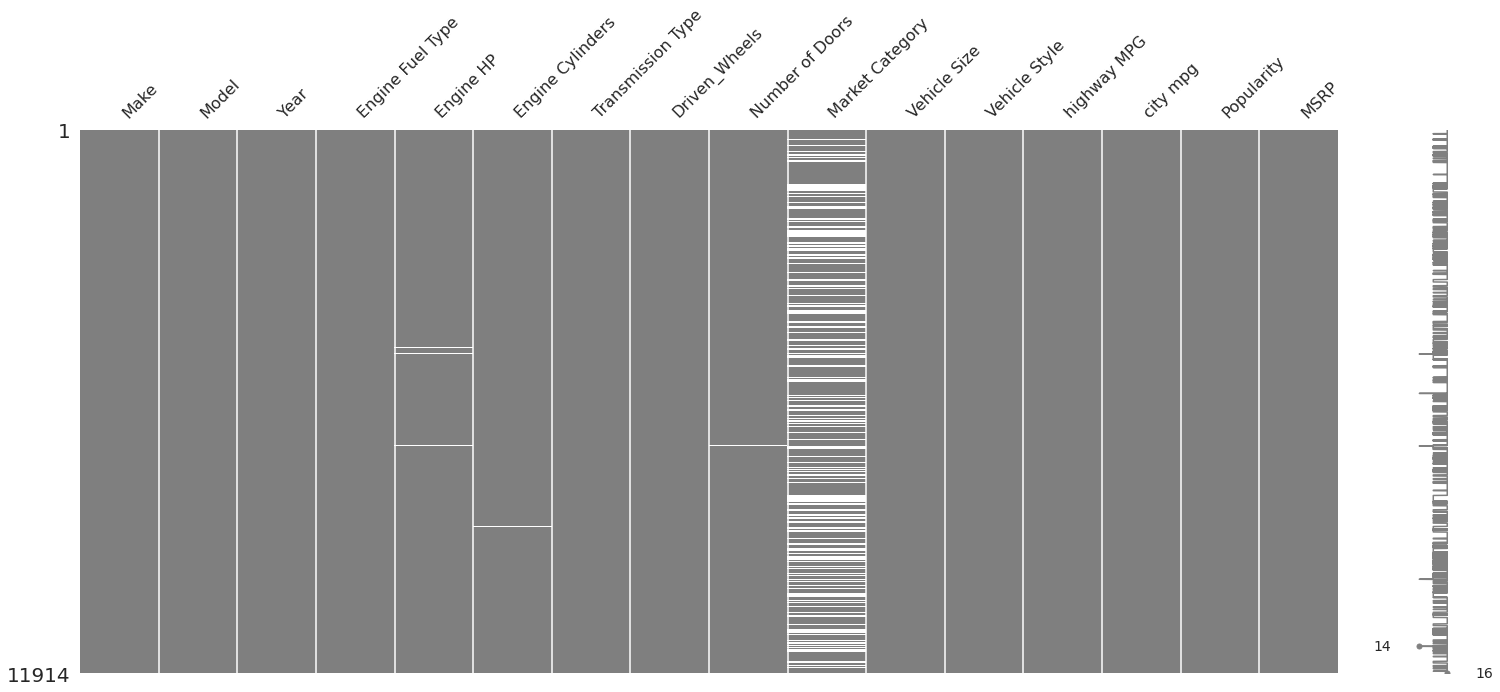

In [784]:
msno.matrix(df1, color = (0.5, 0.5, 0.5))

The above figure shows an overview of nullpoints in the data set; points for which data is missing.

Specifically, there are a lot of missing data points in the "Market Category" column, as well as a few missing points in "Engine HP", "Engine Cylinders" and "Number of Doors".

This indicates that "Market Category" might not be a great variable to depen on for further analysis.

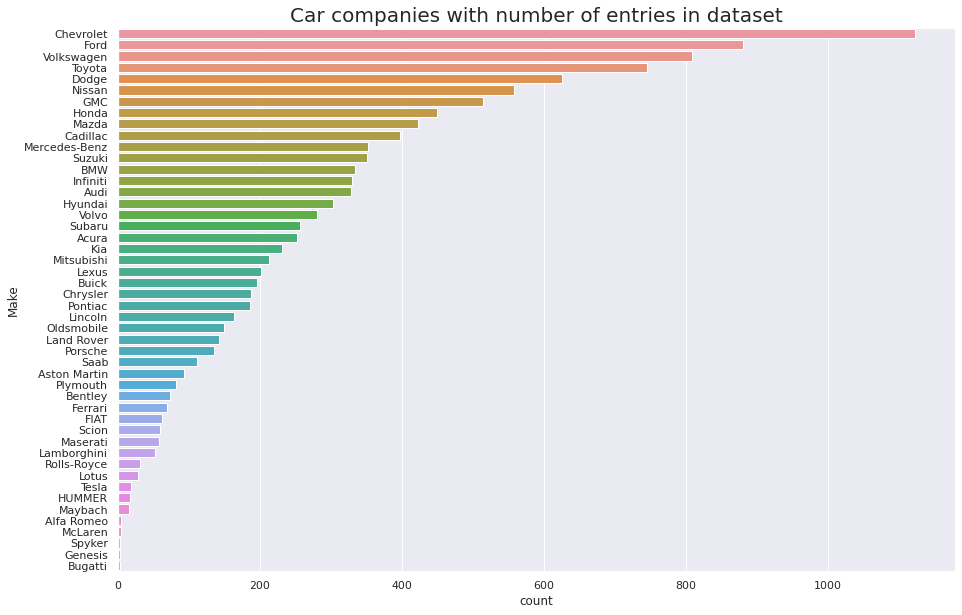

In [785]:
plt.figure(figsize=(15, 10))
sns.countplot(y="Make", 
              data=df1, 
              order = df1["Make"].value_counts().index)
plt.title("Car companies with number of entries in dataset", fontsize = 20)
plt.show()

I will in this assignment focus on the five makes with the most entries in the data set. These are:

1: Chevrolet

2: Ford

3: Volkswagen

4: Toyota

5: Dodge

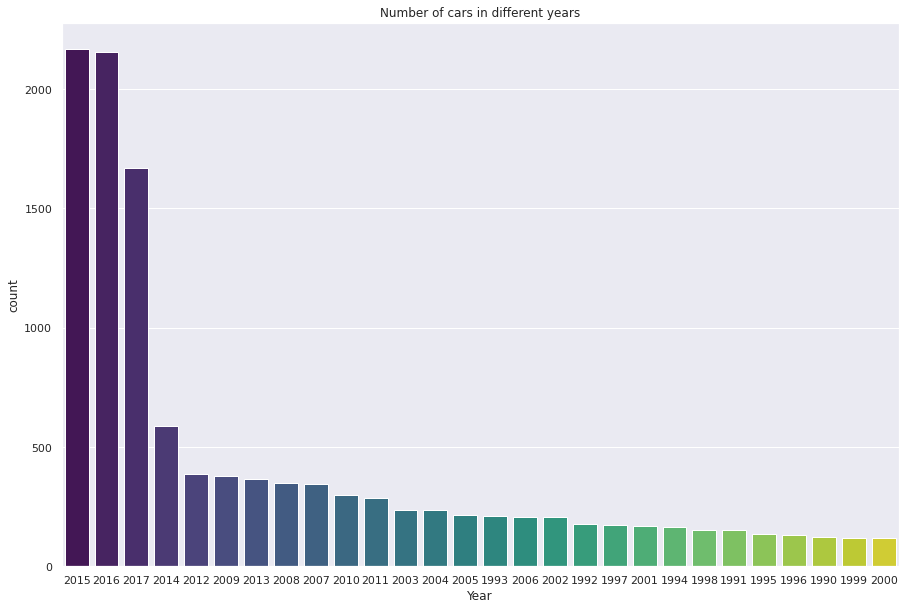

In [786]:
plt.figure(figsize=(15, 10))
sns.countplot(df1.Year, 
              palette="viridis",
              order = df1["Year"].value_counts().index)
plt.title("Number of cars in different years")
plt.show()


As demonstrated by the graph above, there are many more data points from the most recent years. This is likely due to a combination of data not being as rigouresly collected in the earlier years, and the production of cars ramping up in the recent years.

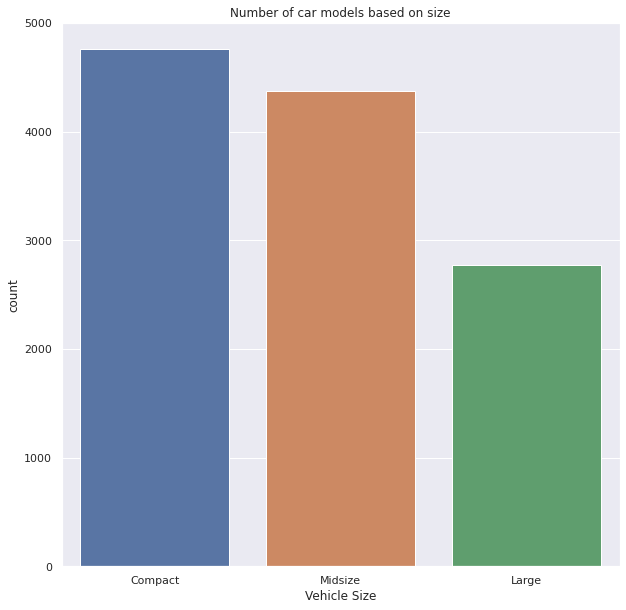

In [787]:
plt.figure(figsize=(10, 10))
plt.title("Number of car models based on size")
sns.countplot(x = 'Vehicle Size', data = df1)

There are more car models clasified as "compact" then of both "midsize" (2nd) and "Large", (3rd, lowest)

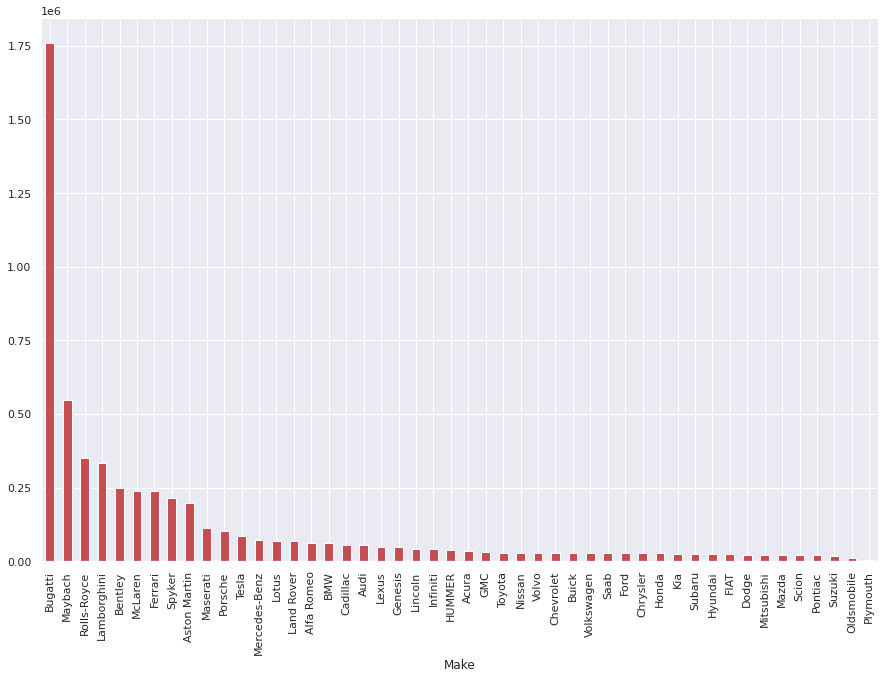

In [788]:
plt.figure(figsize=(15, 10))
df1.groupby(["Make"]).mean()["MSRP"].sort_values(ascending = False).plot(kind = "bar", color = "r")

The above table shows that Bugatti cars have a way higher average MSRP than any other make. Interesting, considering that Bugatti had very few entires in this dataset.

Text(0.5, 1.0, 'Average car price by year')

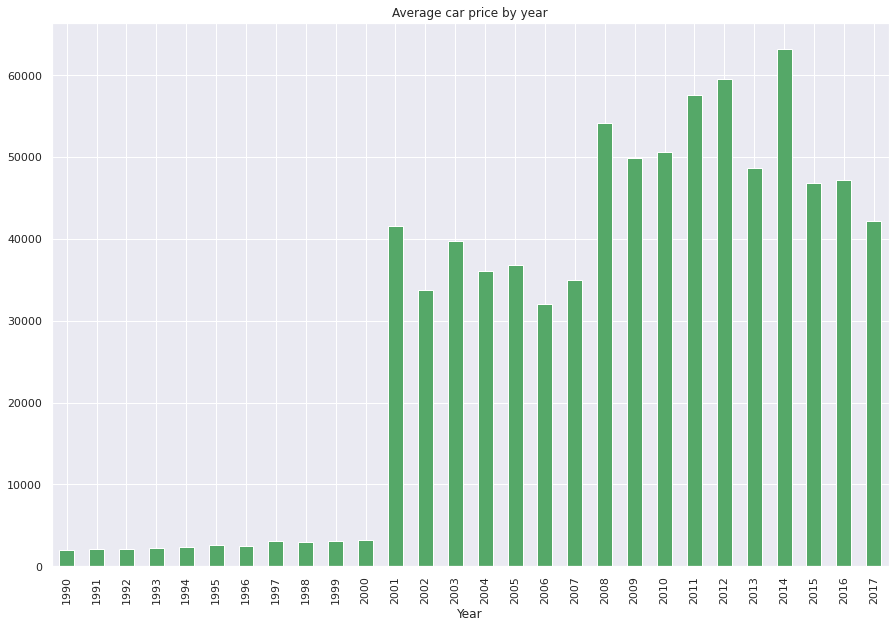

In [789]:
plt.figure(figsize=(15, 10))
df1.groupby("Year")["MSRP"].mean().plot(kind="bar", color="g")
plt.title("Average car price by year")

The above figure shows that the average MSRP for cars exploded after the year 2000. I have not yet found a convincing reason for this. Might simply be poor data.

Text(0.5, 1.0, 'Average car price by year (sorted by price, descending)')

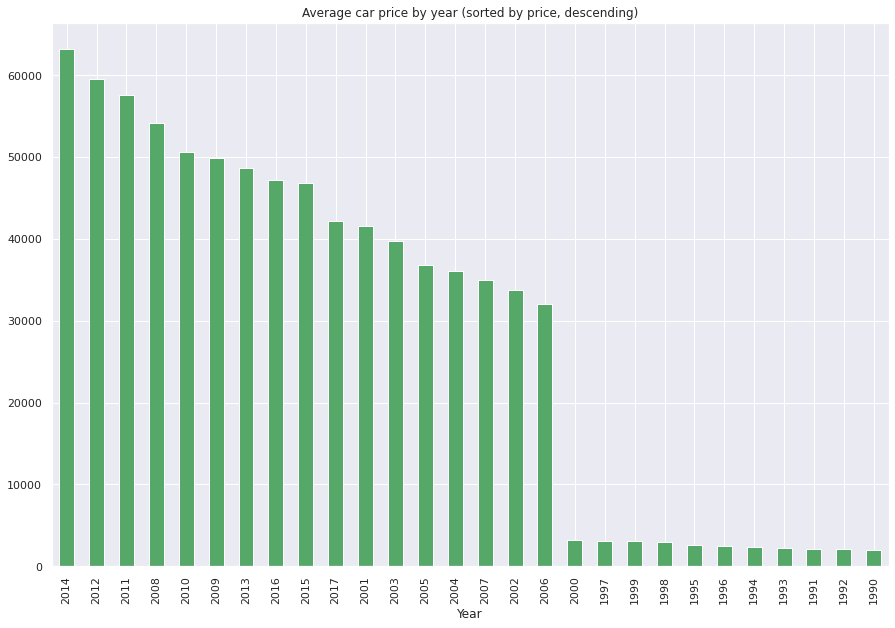

In [790]:
plt.figure(figsize=(15, 10))
df1.groupby("Year")["MSRP"].mean().sort_values(ascending=False).plot(kind="bar", color="g")
plt.title("Average car price by year (sorted by price, descending)")

Text(0.5, 1.0, 'The average price of cars with different transmission types')

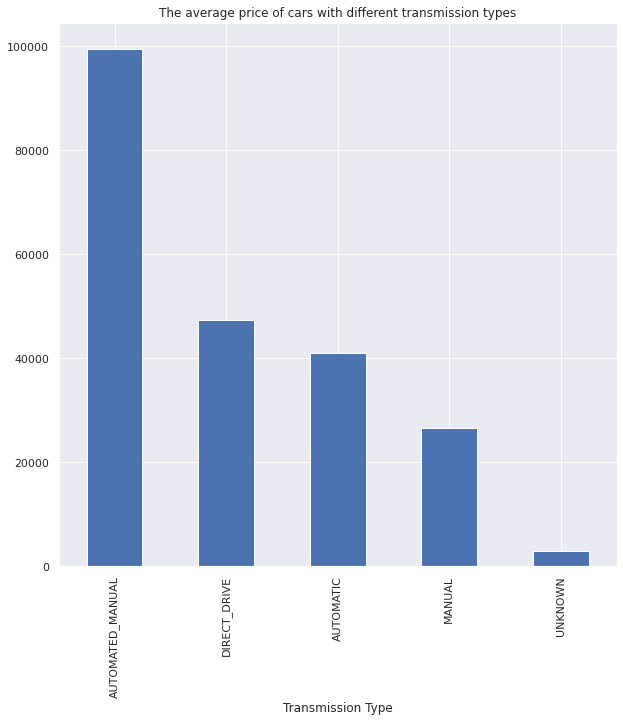

In [791]:
plt.figure(figsize=(10, 10))
df1.groupby("Transmission Type")["MSRP"].mean().sort_values(ascending=False).plot(kind="bar", color="b")
plt.title("The average price of cars with different transmission types")


This table shows that cars with both manual and automatic transmission tend to have a much higher MSRP.

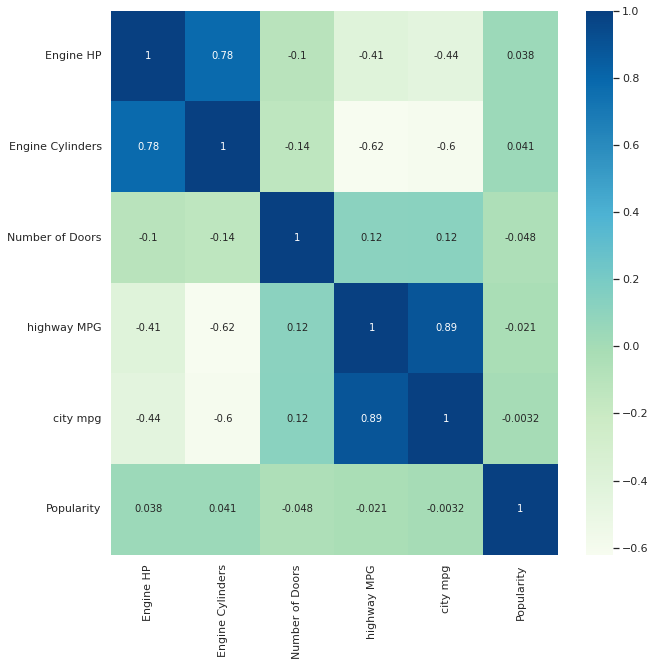

In [792]:
plt.figure(figsize=(10, 10))
heatmap_features = ["Engine HP", "Engine Cylinders", "Number of Doors", "highway MPG", "city mpg", "Popularity"]
heatmap_data = df1[heatmap_features].corr()

sns.heatmap(heatmap_data, cmap = "GnBu", annot = True)

Shows the correlation coefficiency between Engine HP, Engine Cylinders, Number of Doors, City MPG, Highway MPG and Popularity.

We can see that city MPG and highway MPG have a relatively strong correlation, which makes sense.

We can also see that the number of cylinders have a relatively strong negative correlation to both city and highway MPG, and a strong positive correlation to engine HP.

## Data preprocessing

Adding some features to the data.

For the sake of simplicity, assuming each car is still currently being manufactured.

I would like to try and gather this data at a later time

In [793]:
df1["Present Year"] = 2022
df1["Years of Manufacture"] = df1["Present Year"] - df1["Year"]
df1.drop(["Present Year"], inplace = True, axis = 1)
print(x_train.shape)


(9531, 49)


In [794]:
#removing "Market Category" column, as there are so many nan values in it.
df1.drop(["Market Category"], inplace = True, axis = 1)

In [795]:
#Shuffling data for randomness
s_data = shuffle(df1, random_state = 100)
x = s_data.drop(["MSRP"], axis = 1)
y = s_data["MSRP"]

#Dividing data into testing and training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)
#target encoding the data
#calculate the mean target variable for each category and replaces the category variable
#with the mean value. 

#Year
encoder = TargetEncoder(cols="Year")
encoder.fit(x_train["Year"], y_train.to_frame()["MSRP"])
x_train["Year"] = encoder.transform(x_train["Year"])
x_test["Year"] = encoder.transform(x_test["Year"])

#Model
encoder = TargetEncoder(cols="Model")
encoder.fit(x_train["Model"], y_train.to_frame()["MSRP"])
x_train["Model"] = encoder.transform(x_train["Model"])
x_test["Model"] = encoder.transform(x_test["Model"])

#Make
encoder = TargetEncoder(cols="Make")
encoder.fit(x_train["Make"], y_train.to_frame()["MSRP"])
x_train["Make"] = encoder.transform(x_train["Make"])
x_test["Make"] = encoder.transform(x_test["Make"])

print(x_train.shape)
x_train.head()

(9531, 15)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Years of Manufacture
10938,28920.700168,37820.652174,47425.389850,flex-fuel (unleaded/E85),381.0,8.0,AUTOMATIC,four wheel drive,4.0,Large,Extended Cab Pickup,17,13,2031,7
1223,26960.299728,27854.032258,47425.389850,regular unleaded,185.0,4.0,AUTOMATIC,front wheel drive,4.0,Midsize,Sedan,36,27,2202,7
472,237693.379310,261021.637364,47425.389850,premium unleaded (required),562.0,8.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Compact,Convertible,17,13,2774,7
8150,22283.702429,30570.638298,56718.941781,regular unleaded,310.0,8.0,MANUAL,four wheel drive,4.0,Large,Crew Cab Pickup,16,12,1851,14
2038,27017.591040,2798.423005,2355.638095,regular unleaded,199.0,8.0,MANUAL,four wheel drive,2.0,Midsize,2dr SUV,16,13,5657,26


In [796]:
#one hot encoding the data
#each category in a feature is converted to a feature and set to 1 if/when that feature is present.
#only using this where there is a limited set of inputs for the feature, such as transmission type

encoder = OneHotEncoder()
encoder.fit(x_train[["Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Size", "Vehicle Style"]])
ohe_output_train = encoder.transform(x_train[["Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Size", "Vehicle Style"]])
ohe_output_test = encoder.transform(x_test[["Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Size", "Vehicle Style"]])

#print(x_train.shape)
#print(ohe_output_train.shape)


#Concatenating features, and removing the original categories
x_train = pd.concat([x_train, ohe_output_train], axis = 1)
x_test = pd.concat([x_test, ohe_output_test], axis = 1)

#print(x_train.shape)
#print(ohe_output_train.shape)

x_train.drop(["Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Size", "Vehicle Style"], axis = 1, inplace = True)
x_test.drop(["Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Size", "Vehicle Style"], axis = 1, inplace = True)

In [797]:
x_train

,Make,Model,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Years of Manufacture,...,Vehicle Style_7,Vehicle Style_8,Vehicle Style_9,Vehicle Style_10,Vehicle Style_11,Vehicle Style_12,Vehicle Style_13,Vehicle Style_14,Vehicle Style_15,Vehicle Style_16
10938,28920.700168,37820.652174,47425.389850,381.0,8.0,4.0,17,13,2031,7,...,0,0,0,0,0,0,0,0,0,0
1223,26960.299728,27854.032258,47425.389850,185.0,4.0,4.0,36,27,2202,7,...,0,0,0,0,0,0,0,0,0,0
472,237693.379310,261021.637364,47425.389850,562.0,8.0,2.0,17,13,2774,7,...,0,0,0,0,0,0,0,0,0,0
8150,22283.702429,30570.638298,56718.941781,310.0,8.0,4.0,16,12,1851,14,...,0,0,0,0,0,0,0,0,0,0
2038,27017.591040,2798.423005,2355.638095,199.0,8.0,2.0,16,13,5657,26,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,22283.702429,20152.189865,47425.389850,160.0,4.0,4.0,36,25,1851,7,...,0,0,0,0,0,0,0,0,0,0
8774,28555.671492,19046.071429,40019.107143,120.0,4.0,2.0,23,17,1385,19,...,0,1,0,0,0,0,0,0,0,0
2366,28555.671492,15197.368813,38782.080925,140.0,4.0,2.0,33,23,1385,17,...,1,0,0,0,0,0,0,0,0,0
10922,24259.639004,25681.254670,42214.467464,175.0,4.0,4.0,30,25,1439,5,...,0,0,0,1,0,0,0,0,0,0


In [798]:
#normalizing and standardizing
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled.shape

(9531, 49)

In [799]:
#Handeling nan values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
x_train_scaled = imputer.fit_transform(x_train_scaled)
x_test_scaled = imputer.fit_transform(x_test_scaled)

## Analysis take 2

In [836]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train_scaled, y_train)

LinearRegression()

In [829]:
#lists for storing error info
error_mean_sqr = []
error_mean_abs = []

In [830]:
y_predict = model.predict(x_test_scaled)

In [831]:
error_mean_sqr.append(int(mean_squared_error(y_predict, y_test)))
error_mean_abs.append(int(mean_absolute_error(y_predict, y_test)))
error_mean_abs

[4701]

In [837]:
y_predict = pd.DataFrame(y_predict, columns = ["Predicted Output"])
y_predict.head()

,Predicted Output
0,56520.0
1,30550.0
2,16174.0
3,33332.5
4,41505.0


In [839]:
#checking results to see how the model actually performed.
result = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
result.head()
print(result)

      Predicted Output   MSRP
0              56520.0  47800
1              30550.0  27050
2              16174.0  16949
3              33332.5  23390
4              41505.0  41895
...                ...    ...
2378           37780.0  45490
2379           26797.5  27435
2380            5769.0   6954
2381           22399.0  21899
2382           13970.0  21665

[2383 rows x 2 columns]


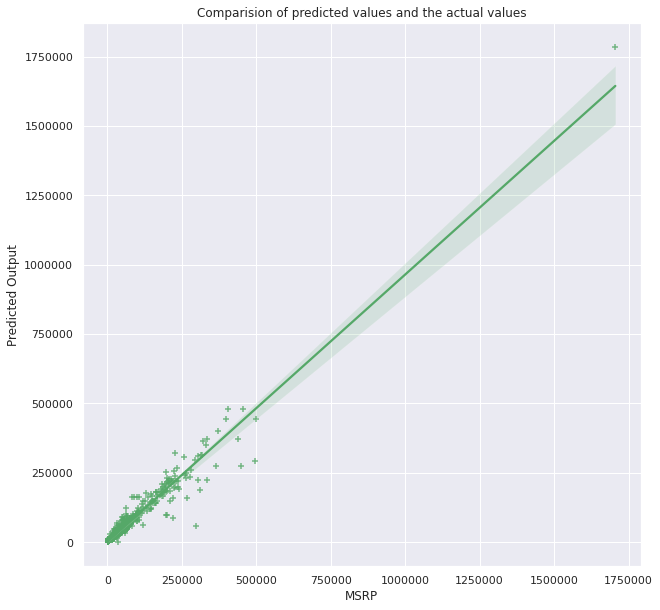

      Predicted Output   MSRP
0              56520.0  47800
1              30550.0  27050
2              16174.0  16949
3              33332.5  23390
4              41505.0  41895
...                ...    ...
2378           37780.0  45490
2379           26797.5  27435
2380            5769.0   6954
2381           22399.0  21899
2382           13970.0  21665

[2383 rows x 2 columns]


In [835]:
#regplot - linear regression output
plt.figure(figsize = (10, 10))
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.regplot(data = result, y = 'Predicted Output', x = 'MSRP', color = 'g', marker = '+')
plt.title("Comparision of predicted values and the actual values")
plt.show()
print(result)

These graphs show there is a single extreme outlier in both MSRP and predicted value

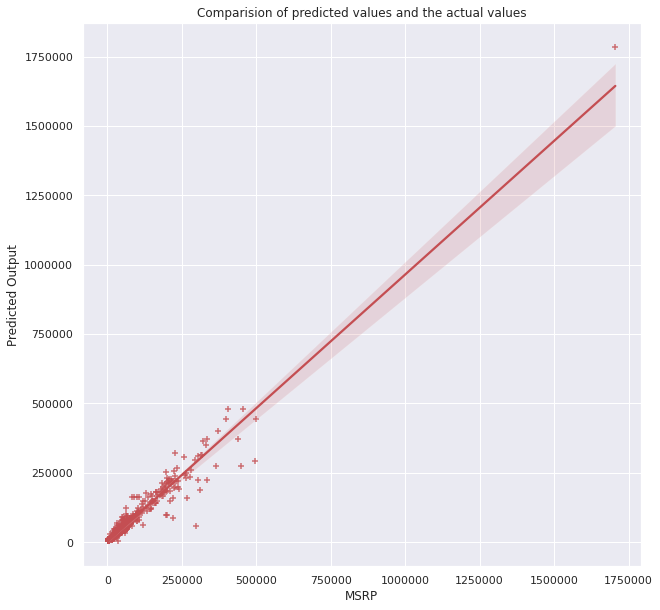

      Predicted Output   MSRP
0              56520.0  47800
1              30550.0  27050
2              16174.0  16949
3              33332.5  23390
4              41505.0  41895
...                ...    ...
2378           37780.0  45490
2379           26797.5  27435
2380            5769.0   6954
2381           22399.0  21899
2382           13970.0  21665

[2383 rows x 2 columns]


In [843]:
#gradient boosting
gradient_boosting_model = GradientBoostingRegressor()
gradient_boosting_model.fit(x_train_scaled, y_train)
y_predict = gradient_boosting_model.predict(x_test_scaled)
y_predict = pd.DataFrame(y_predict, columns = ["Predicted Output"])
retult = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

plt.figure(figsize = (10, 10))
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.regplot(data = result, y = 'Predicted Output', x = 'MSRP', color = 'r', marker = '+')
plt.title("Comparision of predicted values and the actual values")
plt.show()
print(result)

Gradient boositng seems to give the same exact result as linear regression.
Is there i mistake somehwere?

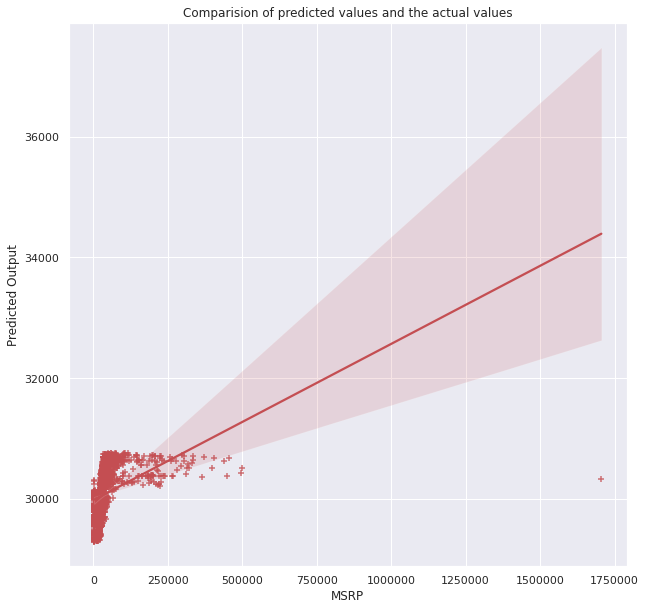

      Predicted Output   MSRP
0         30412.622727  47800
1         29974.085067  27050
2         29537.172204  16949
3         30336.253545  23390
4         30079.728164  41895
...                ...    ...
2378      30259.326512  45490
2379      29883.018987  27435
2380      30077.897863   6954
2381      30239.104245  21899
2382      29374.207552  21665

[2383 rows x 2 columns]


In [844]:
#support vector regressor
model = SVR()
model.fit(x_train_scaled, y_train)
y_predict = model.predict(x_test_scaled)
y_predict = pd.DataFrame(y_predict, columns = ["Predicted Output"])
result = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

plt.figure(figsize = (10, 10))
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.regplot(data = result, y = 'Predicted Output', x = 'MSRP', color = 'r', marker = '+')
plt.title("Comparision of predicted values and the actual values")
plt.show()
print(result)

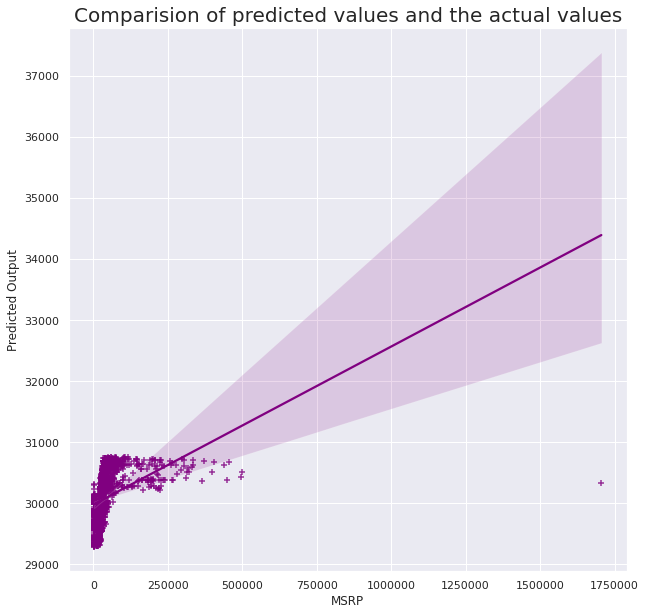

In [849]:
#mlp regression
mlp_model = MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive')
mlp_model.fit(x_train_scaled, y_train)
y_predict = model.predict(x_test_scaled)
y_predict = pd.DataFrame(y_predict, columns = ['Predicted Output'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

plt.figure(figsize = (10, 10))
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.regplot(data = results, y = 'Predicted Output', x = 'MSRP', color = 'purple', marker = "+")
plt.title("Comparision of predicted values and the actual values", fontsize = 20)
plt.show()

As happened previously, the results of using mlp regression and svr regression seem to be identical. I have yet to figure out what, if anything is wrong here. 